In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")


Libraries imported successfully!
Pandas version: 2.3.0
NumPy version: 2.3.1
Matplotlib version: 3.10.3
Seaborn version: 0.13.2


In [8]:
# Utility Functions for EDA (Modular Programming Approach)

def load_and_inspect_data(file_path):
    """
    Load data and provide initial inspection
    """
    print("🔄 Loading data...")
    df = pd.read_csv(file_path)
    
    print(f"✅ Data loaded successfully!")
    print(f"📊 Dataset shape: {df.shape}")
    print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    return df

def get_data_overview(df):
    """
    Comprehensive data overview including types, null values, and basic stats
    """
    print("=" * 50)
    print("🔍 DATA OVERVIEW")
    print("=" * 50)
    
    print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Total Cells: {df.shape[0] * df.shape[1]:,}")
    print(f"Missing Values: {df.isnull().sum().sum():,} ({(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%)")
    
    print("\n📋 Column Information:")
    info_df = pd.DataFrame({
        'Column': df.columns,
        'Data Type': df.dtypes,
        'Non-Null Count': df.count(),
        'Null Count': df.isnull().sum(),
        'Null Percentage': (df.isnull().sum() / len(df) * 100).round(2),
        'Unique Values': df.nunique(),
        'Unique Percentage': (df.nunique() / len(df) * 100).round(2)
    })
    
    return info_df

def analyze_numerical_features(df):
    """
    Analyze numerical features distribution
    """
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"📊 Found {len(numerical_cols)} numerical features:")
    print(numerical_cols)
    
    # Summary statistics
    summary_stats = df[numerical_cols].describe()
    
    return numerical_cols, summary_stats

def analyze_categorical_features(df):
    """
    Analyze categorical features
    """
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    print(f"🏷️ Found {len(categorical_cols)} categorical features:")
    print(categorical_cols)
    
    cat_summary = {}
    for col in categorical_cols:
        cat_summary[col] = {
            'unique_count': df[col].nunique(),
            'top_value': df[col].mode()[0] if not df[col].empty else None,
            'top_freq': df[col].value_counts().iloc[0] if not df[col].empty else None,
            'top_percentage': (df[col].value_counts().iloc[0] / len(df) * 100) if not df[col].empty else None
        }
    
    return categorical_cols, cat_summary

def detect_outliers_iqr(df, column):
    """
    Detect outliers using IQR method
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers, lower_bound, upper_bound

def safe_kde_plot(data, ax, color='red', linewidth=2):
    """
    Safely plot KDE with error handling
    """
    try:
        # Check if data has sufficient variance
        if len(data.unique()) > 1 and data.std() > 1e-10:
            data.plot.kde(ax=ax, color=color, linewidth=linewidth)
            return True
        else:
            ax.text(0.5, 0.95, 'Insufficient variance for KDE', 
                   transform=ax.transAxes, ha='center', va='top', 
                   bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7),
                   fontsize=8)
            return False
    except Exception as e:
        ax.text(0.5, 0.95, f'KDE Error: {str(e)[:20]}...', 
               transform=ax.transAxes, ha='center', va='top', 
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
               fontsize=8)
        return False

def plot_numerical_distributions(df, numerical_cols, max_cols=3):
    """
    Plot distributions for numerical features with robust error handling
    """
    n_cols = len(numerical_cols)
    n_rows = (n_cols + max_cols - 1) // max_cols
    
    fig, axes = plt.subplots(n_rows, max_cols, figsize=(15, 4*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(numerical_cols):
        if i < len(axes):
            # Get clean data
            clean_data = df[col].dropna()
            
            # Check if data has sufficient variance for KDE
            has_variance = len(clean_data.unique()) > 1 and clean_data.std() > 1e-10
            
            # Histogram
            axes[i].hist(clean_data, bins=50, alpha=0.7, density=True, color='skyblue', edgecolor='black')
            
            # Add KDE only if data has sufficient variance
            if not clean_data.empty and has_variance:
                try:
                    clean_data.plot.kde(ax=axes[i], color='red', linewidth=2)
                except Exception as e:
                    # If KDE fails, add a note
                    axes[i].text(0.5, 0.95, f'KDE unavailable\n({str(e)[:30]}...)', 
                               transform=axes[i].transAxes, ha='center', va='top', 
                               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                               fontsize=8)
            elif not has_variance:
                # Add note for constant/low variance data
                axes[i].text(0.5, 0.95, 'Low/No variance data\nKDE not applicable', 
                           transform=axes[i].transAxes, ha='center', va='top', 
                           bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7),
                           fontsize=8)
            
            axes[i].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Density')
            axes[i].grid(True, alpha=0.3)
            
            # Add basic statistics as text
            if not clean_data.empty:
                stats_text = f'Mean: {clean_data.mean():.2f}\nStd: {clean_data.std():.2f}\nUnique: {clean_data.nunique()}'
                axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes, 
                           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                           fontsize=8)
    
    # Hide empty subplots
    for i in range(len(numerical_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_categorical_distributions(df, categorical_cols, max_cols=2):
    """
    Plot distributions for categorical features
    """
    n_cols = len(categorical_cols)
    n_rows = (n_cols + max_cols - 1) // max_cols
    
    fig, axes = plt.subplots(n_rows, max_cols, figsize=(15, 4*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(categorical_cols):
        if i < len(axes):
            value_counts = df[col].value_counts().head(10)  # Top 10 categories
            
            value_counts.plot(kind='bar', ax=axes[i], color='lightcoral', alpha=0.8)
            axes[i].set_title(f'Distribution of {col} (Top 10)', fontsize=12, fontweight='bold')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(len(categorical_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

print("🛠️ Utility functions defined successfully!")
print("📋 Available functions:")
print("• load_and_inspect_data() - Load and inspect dataset")
print("• get_data_overview() - Comprehensive data overview")
print("• analyze_numerical_features() - Analyze numerical features")
print("• analyze_categorical_features() - Analyze categorical features")
print("• detect_outliers_iqr() - Detect outliers using IQR method")
print("• safe_kde_plot() - Safely plot KDE with error handling")
print("• plot_numerical_distributions() - Plot numerical distributions with robust error handling")
print("• plot_categorical_distributions() - Plot categorical distributions")


🛠️ Utility functions defined successfully!
📋 Available functions:
• load_and_inspect_data() - Load and inspect dataset
• get_data_overview() - Comprehensive data overview
• analyze_numerical_features() - Analyze numerical features
• analyze_categorical_features() - Analyze categorical features
• detect_outliers_iqr() - Detect outliers using IQR method
• safe_kde_plot() - Safely plot KDE with error handling
• plot_numerical_distributions() - Plot numerical distributions with robust error handling
• plot_categorical_distributions() - Plot categorical distributions


In [9]:
# Load the dataset
data_path = '../data/raw/data.csv'
df = load_and_inspect_data(data_path)

# Display first few rows
print("\n🔍 First 5 rows:")
print(df.head())

print("\n🔍 Last 5 rows:")
print(df.tail())

print("\n📝 Column names:")
print(df.columns.tolist())


🔄 Loading data...
✅ Data loaded successfully!
📊 Dataset shape: (95662, 16)
💾 Memory usage: 66.48 MB

🔍 First 5 rows:
         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          

In [10]:
# Get comprehensive data overview
info_df = get_data_overview(df)
display(info_df)

# Check data types in detail
print("\n📊 Data Types Summary:")
print(df.dtypes.value_counts())

# Sample of each column to understand the data
print("\n🔍 Sample values from each column:")
for col in df.columns:
    sample_values = df[col].dropna().unique()[:5]
    print(f"{col}: {sample_values}")


🔍 DATA OVERVIEW
Dataset Shape: 95,662 rows × 16 columns
Total Cells: 1,530,592
Missing Values: 0 (0.00%)

📋 Column Information:


,Column,Data Type,Non-Null Count,Null Count,Null Percentage,Unique Values,Unique Percentage
TransactionId,TransactionId,object,95662,0,0.0,95662,100.00
BatchId,BatchId,object,95662,0,0.0,94809,99.11
AccountId,AccountId,object,95662,0,0.0,3633,3.80
SubscriptionId,SubscriptionId,object,95662,0,0.0,3627,3.79
CustomerId,CustomerId,object,95662,0,0.0,3742,3.91
CurrencyCode,CurrencyCode,object,95662,0,0.0,1,0.00
CountryCode,CountryCode,int64,95662,0,0.0,1,0.00
ProviderId,ProviderId,object,95662,0,0.0,6,0.01
ProductId,ProductId,object,95662,0,0.0,23,0.02
ProductCategory,ProductCategory,object,95662,0,0.0,9,0.01



📊 Data Types Summary:
object     11
int64       4
float64     1
Name: count, dtype: int64

🔍 Sample values from each column:
TransactionId: ['TransactionId_76871' 'TransactionId_73770' 'TransactionId_26203'
 'TransactionId_380' 'TransactionId_28195']
BatchId: ['BatchId_36123' 'BatchId_15642' 'BatchId_53941' 'BatchId_102363'
 'BatchId_38780']
AccountId: ['AccountId_3957' 'AccountId_4841' 'AccountId_4229' 'AccountId_648'
 'AccountId_1078']
SubscriptionId: ['SubscriptionId_887' 'SubscriptionId_3829' 'SubscriptionId_222'
 'SubscriptionId_2185' 'SubscriptionId_4238']
CustomerId: ['CustomerId_4406' 'CustomerId_4683' 'CustomerId_988' 'CustomerId_1432'
 'CustomerId_2858']
CurrencyCode: ['UGX']
CountryCode: [256]
ProviderId: ['ProviderId_6' 'ProviderId_4' 'ProviderId_1' 'ProviderId_5'
 'ProviderId_3']
ProductId: ['ProductId_10' 'ProductId_6' 'ProductId_1' 'ProductId_21' 'ProductId_3']
ProductCategory: ['airtime' 'financial_services' 'utility_bill' 'data_bundles' 'tv']
ChannelId: ['ChannelId_3'

In [11]:
# Analyze numerical features
numerical_cols, summary_stats = analyze_numerical_features(df)

print("\n📈 Summary Statistics for Numerical Features:")
display(summary_stats)

# Additional statistics
print("\n📊 Additional Statistical Measures:")
additional_stats = pd.DataFrame({
    'Skewness': df[numerical_cols].skew(),
    'Kurtosis': df[numerical_cols].kurtosis(),
    'Coefficient_of_Variation': (df[numerical_cols].std() / df[numerical_cols].mean() * 100).round(2)
})
display(additional_stats)

# Check for zero and negative values in Amount column (if exists)
if 'Amount' in df.columns:
    print(f"\n💰 Amount Analysis:")
    print(f"Positive amounts (debits): {(df['Amount'] > 0).sum():,} ({(df['Amount'] > 0).mean()*100:.1f}%)")
    print(f"Negative amounts (credits): {(df['Amount'] < 0).sum():,} ({(df['Amount'] < 0).mean()*100:.1f}%)")
    print(f"Zero amounts: {(df['Amount'] == 0).sum():,} ({(df['Amount'] == 0).mean()*100:.1f}%)")
    print(f"Amount range: {df['Amount'].min():.2f} to {df['Amount'].max():.2f}")

# Check Value column relationship with Amount
if 'Value' in df.columns and 'Amount' in df.columns:
    print(f"\n🔄 Value vs Amount Relationship:")
    print(f"Value == |Amount|: {(df['Value'] == df['Amount'].abs()).sum():,} matches out of {len(df):,} records")
    print(f"Match percentage: {(df['Value'] == df['Amount'].abs()).mean()*100:.1f}%")


📊 Found 5 numerical features:
['CountryCode', 'Amount', 'Value', 'PricingStrategy', 'FraudResult']

📈 Summary Statistics for Numerical Features:


,CountryCode,Amount,Value,PricingStrategy,FraudResult
count,95662.0,9.566200e+04,9.566200e+04,95662.000000,95662.000000
mean,256.0,6.717846e+03,9.900584e+03,2.255974,0.002018
std,0.0,1.233068e+05,1.231221e+05,0.732924,0.044872
min,256.0,-1.000000e+06,2.000000e+00,0.000000,0.000000
25%,256.0,-5.000000e+01,2.750000e+02,2.000000,0.000000
50%,256.0,1.000000e+03,1.000000e+03,2.000000,0.000000
75%,256.0,2.800000e+03,5.000000e+03,2.000000,0.000000
max,256.0,9.880000e+06,9.880000e+06,4.000000,1.000000



📊 Additional Statistical Measures:


,Skewness,Kurtosis,Coefficient_of_Variation
CountryCode,0.000000,0.000000,0.00
Amount,51.098490,3363.127739,1835.51
Value,51.291086,3378.069274,1243.58
PricingStrategy,1.659057,2.087534,32.49
FraudResult,22.196295,490.685762,2224.10



💰 Amount Analysis:
Positive amounts (debits): 57,473 (60.1%)
Negative amounts (credits): 38,189 (39.9%)
Zero amounts: 0 (0.0%)
Amount range: -1000000.00 to 9880000.00

🔄 Value vs Amount Relationship:
Value == |Amount|: 93,097 matches out of 95,662 records
Match percentage: 97.3%


📊 Plotting distributions of numerical features...


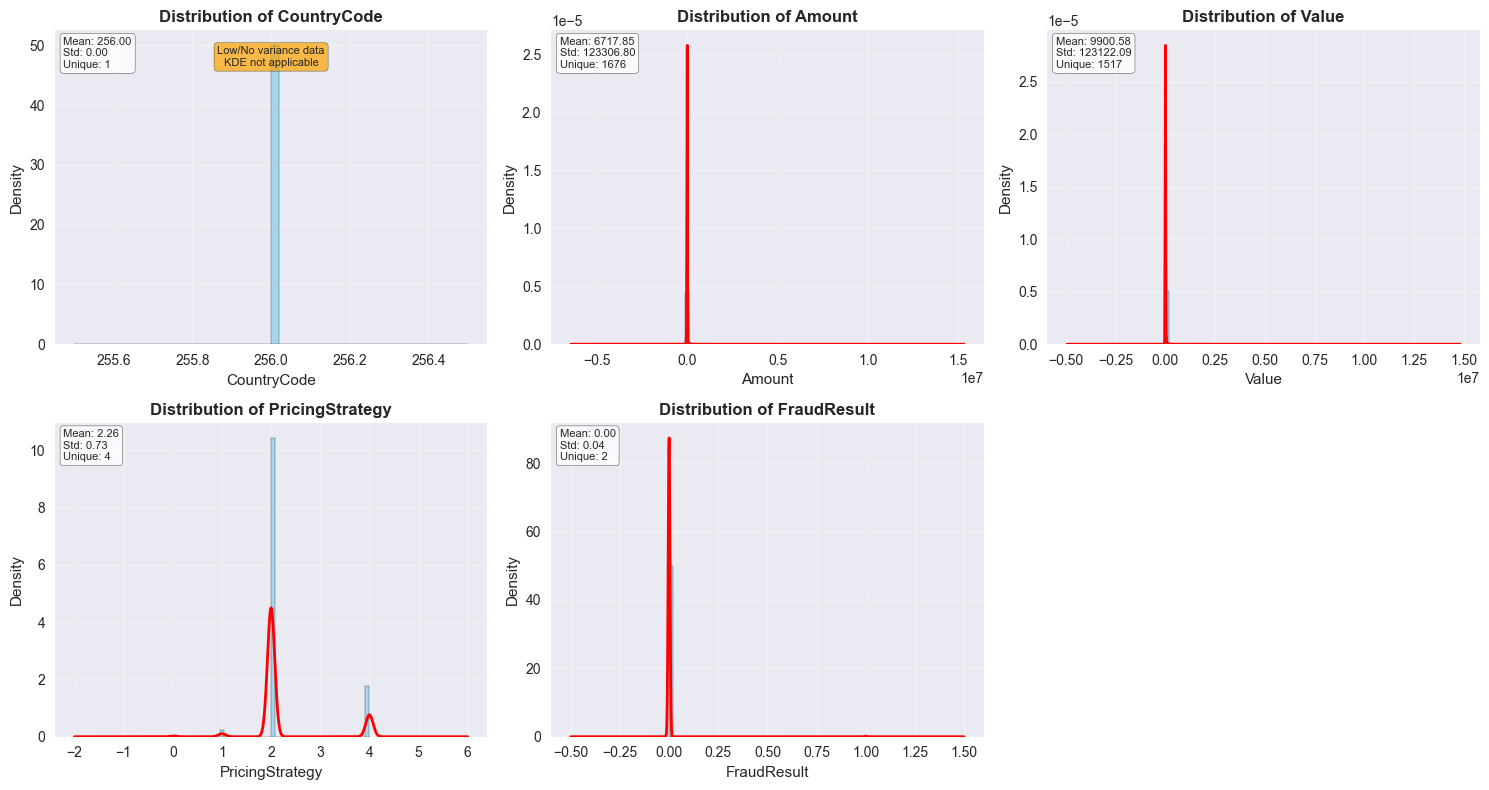

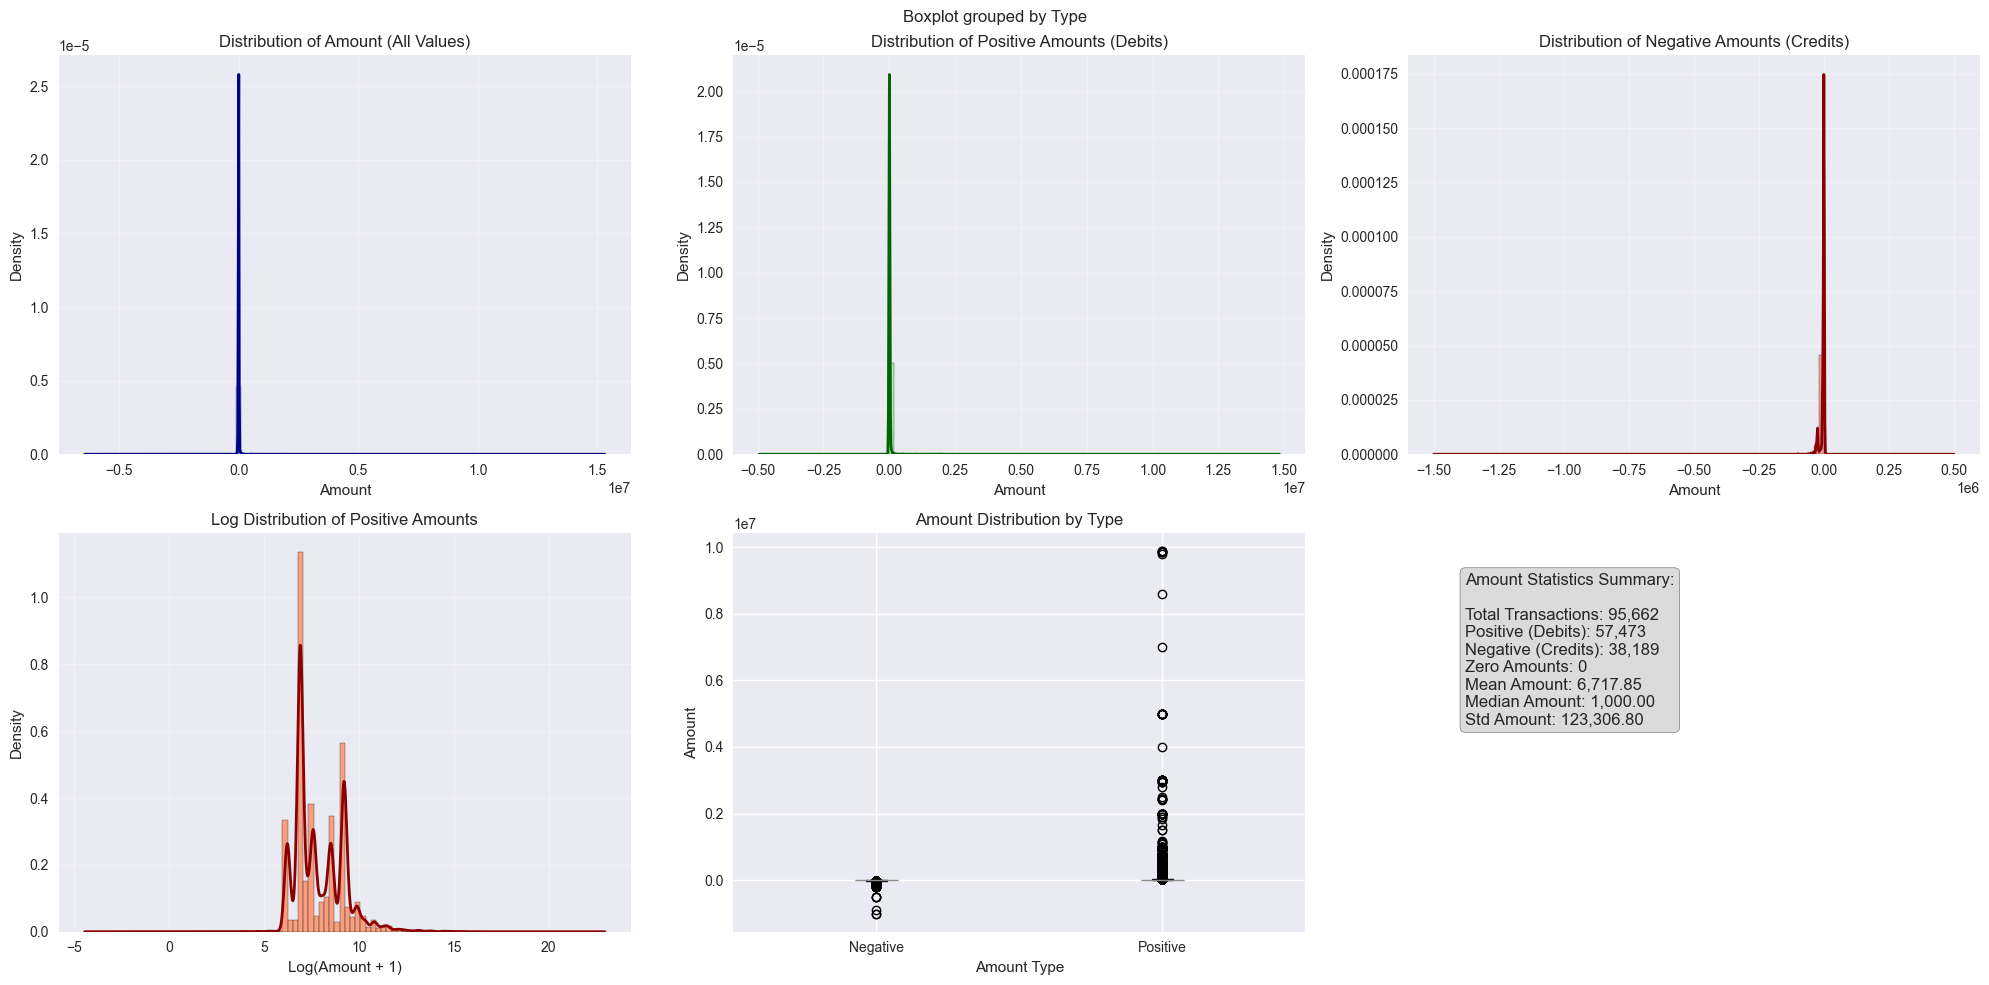

In [12]:
# Plot distributions of numerical features
print("📊 Plotting distributions of numerical features...")
plot_numerical_distributions(df, numerical_cols)

# Special focus on Amount and Value if they exist
if 'Amount' in df.columns:
    plt.figure(figsize=(20, 10))
    
    # Amount distribution (all values)
    plt.subplot(2, 3, 1)
    plt.hist(df['Amount'].dropna(), bins=50, alpha=0.7, color='lightblue', edgecolor='black', density=True)
    safe_kde_plot(df['Amount'].dropna(), plt.gca(), color='darkblue')
    plt.title('Distribution of Amount (All Values)')
    plt.xlabel('Amount')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    
    # Positive amounts only
    plt.subplot(2, 3, 2)
    positive_amounts = df[df['Amount'] > 0]['Amount'].dropna()
    if not positive_amounts.empty:
        plt.hist(positive_amounts, bins=50, alpha=0.7, color='lightgreen', edgecolor='black', density=True)
        safe_kde_plot(positive_amounts, plt.gca(), color='darkgreen')
        plt.title('Distribution of Positive Amounts (Debits)')
        plt.xlabel('Amount')
        plt.ylabel('Density')
        plt.grid(True, alpha=0.3)
    
    # Negative amounts only
    plt.subplot(2, 3, 3)
    negative_amounts = df[df['Amount'] < 0]['Amount'].dropna()
    if not negative_amounts.empty:
        plt.hist(negative_amounts, bins=50, alpha=0.7, color='lightcoral', edgecolor='black', density=True)
        safe_kde_plot(negative_amounts, plt.gca(), color='darkred')
        plt.title('Distribution of Negative Amounts (Credits)')
        plt.xlabel('Amount')
        plt.ylabel('Density')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No negative amounts found', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Distribution of Negative Amounts (Credits)')
    
    # Log scale for positive amounts
    plt.subplot(2, 3, 4)
    if not positive_amounts.empty:
        positive_amounts_log = np.log1p(positive_amounts)  # log1p to handle zeros
        plt.hist(positive_amounts_log, bins=50, alpha=0.7, color='coral', edgecolor='black', density=True)
        safe_kde_plot(positive_amounts_log, plt.gca(), color='darkred')
        plt.title('Log Distribution of Positive Amounts')
        plt.xlabel('Log(Amount + 1)')
        plt.ylabel('Density')
        plt.grid(True, alpha=0.3)
    
    # Box plot by sign
    plt.subplot(2, 3, 5)
    amounts_with_sign = df['Amount'].dropna()
    amount_categories = ['Negative' if x < 0 else 'Zero' if x == 0 else 'Positive' for x in amounts_with_sign]
    amounts_df = pd.DataFrame({'Amount': amounts_with_sign, 'Type': amount_categories})
    amounts_df.boxplot(column='Amount', by='Type', ax=plt.gca())
    plt.title('Amount Distribution by Type')
    plt.xlabel('Amount Type')
    plt.ylabel('Amount')
    
    # Amount statistics summary
    plt.subplot(2, 3, 6)
    amount_stats = {
        'Total Transactions': len(df),
        'Positive (Debits)': (df['Amount'] > 0).sum(),
        'Negative (Credits)': (df['Amount'] < 0).sum(),
        'Zero Amounts': (df['Amount'] == 0).sum(),
        'Mean Amount': df['Amount'].mean(),
        'Median Amount': df['Amount'].median(),
        'Std Amount': df['Amount'].std()
    }
    
    plt.axis('off')
    stats_text = '\n'.join([f'{k}: {v:,.2f}' if isinstance(v, float) else f'{k}: {v:,}' for k, v in amount_stats.items()])
    plt.text(0.1, 0.9, 'Amount Statistics Summary:\n\n' + stats_text, 
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


In [13]:
# Analyze categorical features
categorical_cols, cat_summary = analyze_categorical_features(df)

# Display categorical summary as DataFrame
cat_summary_df = pd.DataFrame(cat_summary).T
print("\n🏷️ Categorical Features Summary:")
display(cat_summary_df)

# Special analysis for key categorical features
key_categorical = ['ChannelId', 'ProductCategory', 'PricingStrategy', 'CurrencyCode', 'CountryCode']
existing_key_categorical = [col for col in key_categorical if col in df.columns]

if existing_key_categorical:
    print(f"\n🔍 Detailed analysis of key categorical features:")
    for col in existing_key_categorical:
        print(f"\n--- {col} ---")
        value_counts = df[col].value_counts()
        print(f"Unique values: {df[col].nunique()}")
        print(f"Top 5 values:")
        print(value_counts.head())
        print(f"Bottom 5 values:")
        print(value_counts.tail())

# Check for high cardinality features (potential ID columns)
print(f"\n🔢 High Cardinality Features (>1000 unique values):")
high_cardinality = []
for col in categorical_cols:
    if df[col].nunique() > 1000:
        high_cardinality.append(col)
        print(f"{col}: {df[col].nunique():,} unique values")

if not high_cardinality:
    print("No high cardinality categorical features found.")


🏷️ Found 11 categorical features:
['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'TransactionStartTime']

🏷️ Categorical Features Summary:


,unique_count,top_value,top_freq,top_percentage
TransactionId,95662,TransactionId_1,1,0.001045
BatchId,94809,BatchId_67019,28,0.02927
AccountId,3633,AccountId_4841,30893,32.29391
SubscriptionId,3627,SubscriptionId_3829,32630,34.109678
CustomerId,3742,CustomerId_7343,4091,4.276515
CurrencyCode,1,UGX,95662,100.0
ProviderId,6,ProviderId_4,38189,39.920763
ProductId,23,ProductId_6,32635,34.114905
ProductCategory,9,financial_services,45405,47.463988
ChannelId,4,ChannelId_3,56935,59.516841



🔍 Detailed analysis of key categorical features:

--- ChannelId ---
Unique values: 4
Top 5 values:
ChannelId
ChannelId_3    56935
ChannelId_2    37141
ChannelId_5     1048
ChannelId_1      538
Name: count, dtype: int64
Bottom 5 values:
ChannelId
ChannelId_3    56935
ChannelId_2    37141
ChannelId_5     1048
ChannelId_1      538
Name: count, dtype: int64

--- ProductCategory ---
Unique values: 9
Top 5 values:
ProductCategory
financial_services    45405
airtime               45027
utility_bill           1920
data_bundles           1613
tv                     1279
Name: count, dtype: int64
Bottom 5 values:
ProductCategory
tv           1279
ticket        216
movies        175
transport      25
other           2
Name: count, dtype: int64

--- PricingStrategy ---
Unique values: 4
Top 5 values:
PricingStrategy
2    79848
4    13562
1     1867
0      385
Name: count, dtype: int64
Bottom 5 values:
PricingStrategy
2    79848
4    13562
1     1867
0      385
Name: count, dtype: int64

--- Curren

📊 Plotting distributions of categorical features...


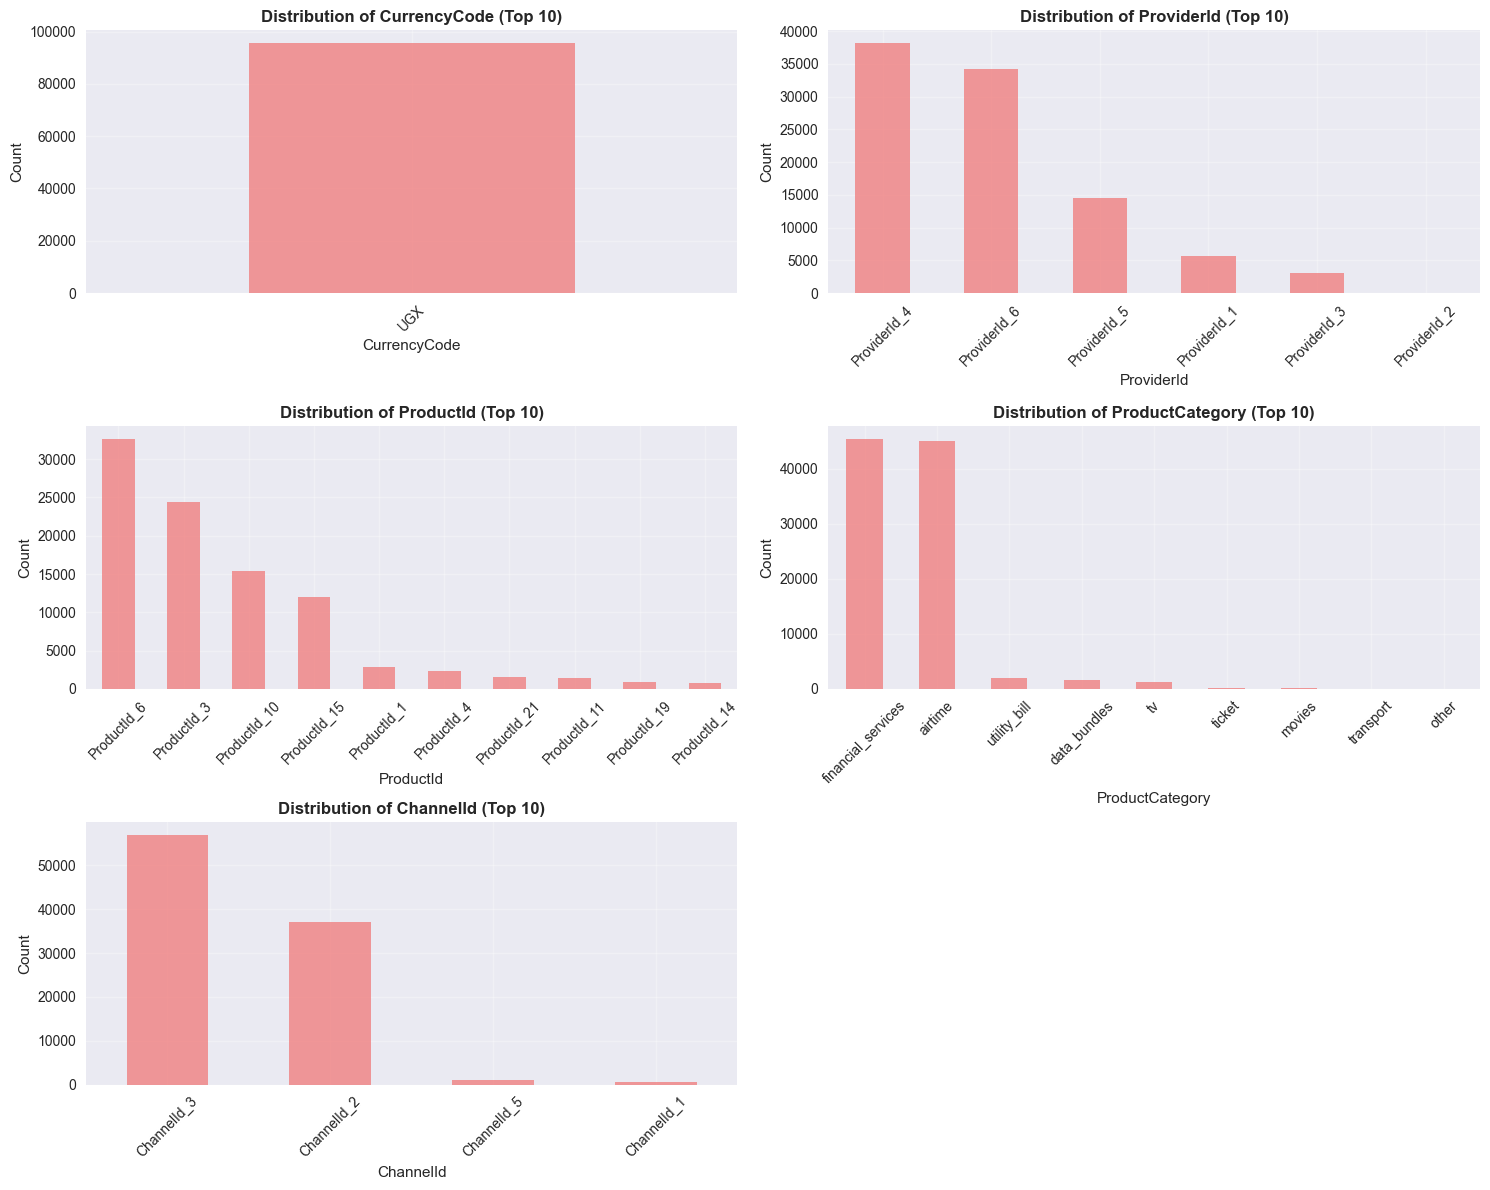

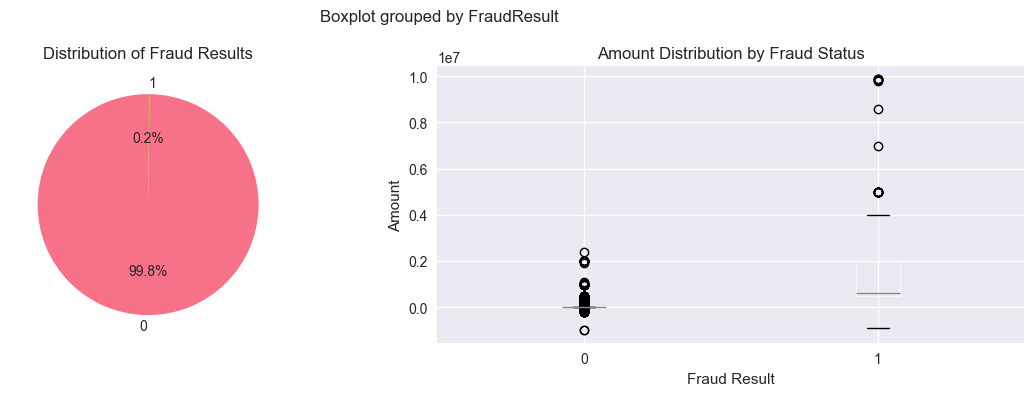


🚨 Fraud Analysis:
Total fraud cases: 193
Total non-fraud cases: 95,469
Fraud rate: 0.20%


In [14]:
# Plot categorical distributions (excluding high cardinality features)
low_cardinality_cats = [col for col in categorical_cols if col not in high_cardinality and df[col].nunique() <= 50]

if low_cardinality_cats:
    print("📊 Plotting distributions of categorical features...")
    plot_categorical_distributions(df, low_cardinality_cats)
else:
    print("⚠️ No suitable categorical features for plotting (all have too many categories)")

# Special focus on Fraud Result if exists
if 'FraudResult' in df.columns:
    plt.figure(figsize=(12, 4))
    
    # Fraud distribution
    plt.subplot(1, 2, 1)
    fraud_counts = df['FraudResult'].value_counts()
    plt.pie(fraud_counts.values, labels=fraud_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Fraud Results')
    
    # Fraud vs Amount
    plt.subplot(1, 2, 2)
    if 'Amount' in df.columns:
        df.boxplot(column='Amount', by='FraudResult', ax=plt.gca())
        plt.title('Amount Distribution by Fraud Status')
        plt.xlabel('Fraud Result')
        plt.ylabel('Amount')
    
    plt.tight_layout()
    plt.show()
    
    # Fraud statistics
    print(f"\n🚨 Fraud Analysis:")
    print(f"Total fraud cases: {fraud_counts.get(1, 0):,}")
    print(f"Total non-fraud cases: {fraud_counts.get(0, 0):,}")
    print(f"Fraud rate: {fraud_counts.get(1, 0) / len(df) * 100:.2f}%")


🔗 Analyzing correlations between numerical features...


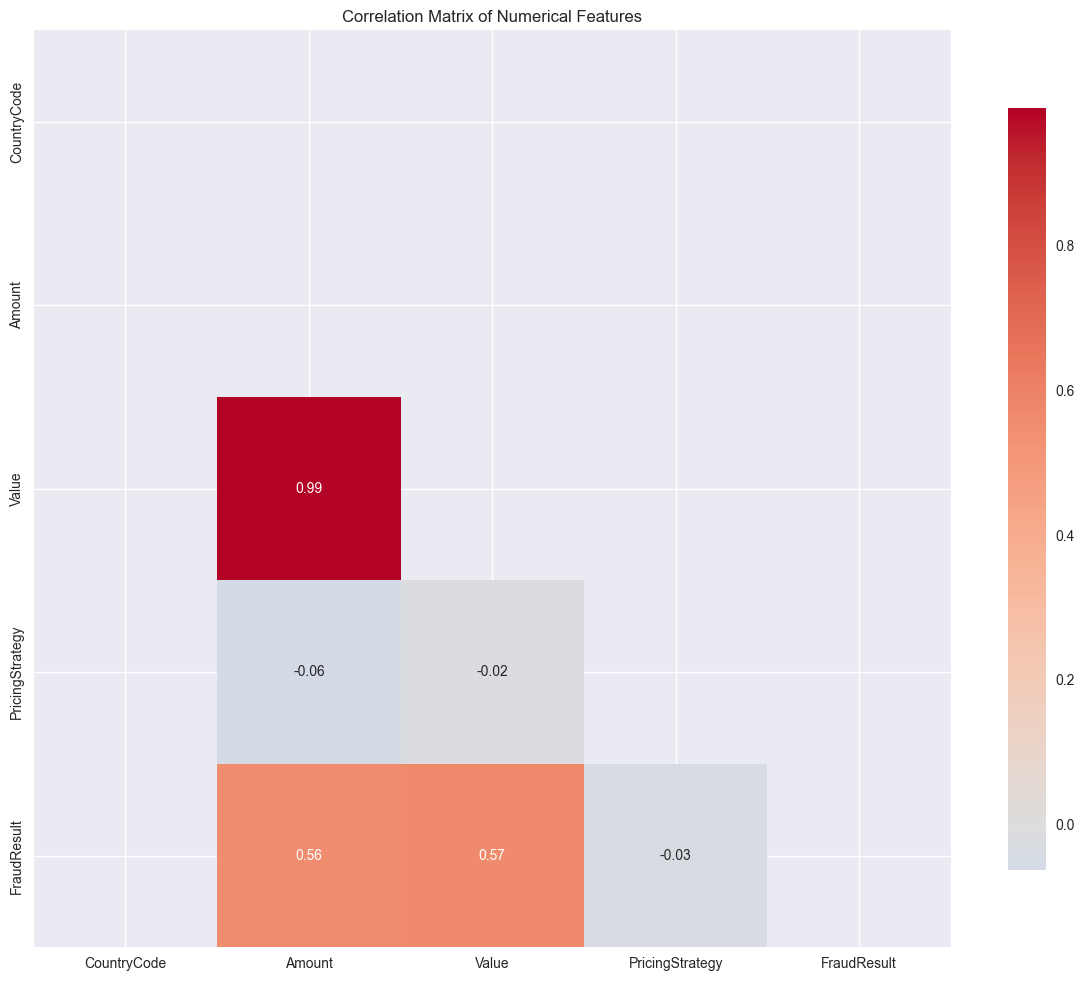


🔍 High Correlations (|correlation| > 0.7):


,Feature 1,Feature 2,Correlation
0,Amount,Value,0.989692



🎯 Correlations with FraudResult:
Value              0.566739
Amount             0.557370
PricingStrategy   -0.033821
CountryCode             NaN
Name: FraudResult, dtype: float64


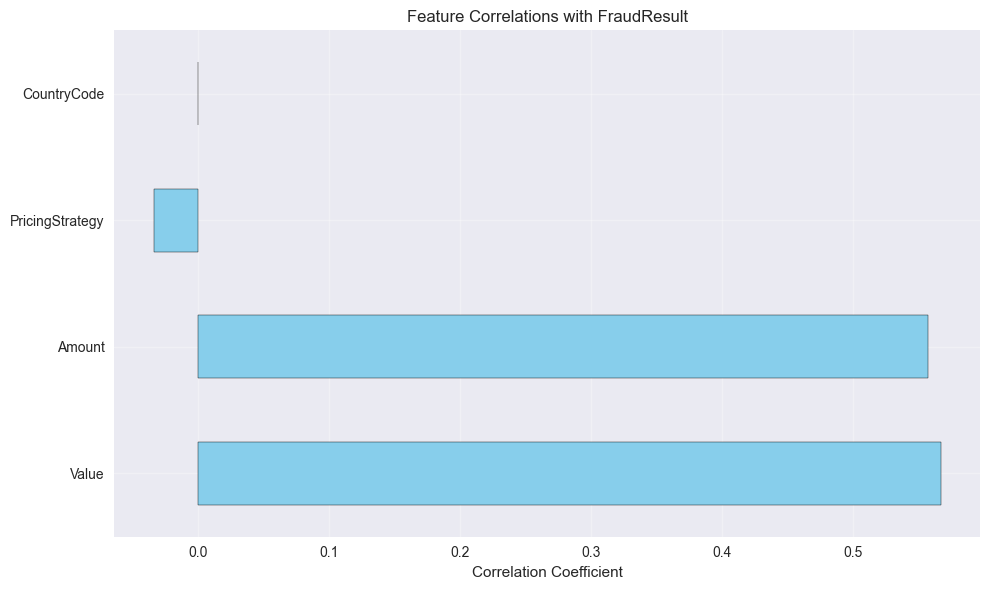

In [15]:
# Correlation analysis for numerical features
if len(numerical_cols) > 1:
    print("🔗 Analyzing correlations between numerical features...")
    
    # Calculate correlation matrix
    correlation_matrix = df[numerical_cols].corr()
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Upper triangle mask
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()
    
    # Find high correlations (excluding self-correlation)
    print("\n🔍 High Correlations (|correlation| > 0.7):")
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.7:
                high_corr_pairs.append({
                    'Feature 1': correlation_matrix.columns[i],
                    'Feature 2': correlation_matrix.columns[j],
                    'Correlation': corr_value
                })
    
    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs)
        display(high_corr_df)
    else:
        print("No high correlations found (|correlation| > 0.7)")
    
    # Correlation with target variable (FraudResult) if exists
    if 'FraudResult' in numerical_cols:
        print("\n🎯 Correlations with FraudResult:")
        fraud_correlations = correlation_matrix['FraudResult'].drop('FraudResult').sort_values(key=abs, ascending=False)
        print(fraud_correlations)
        
        # Plot correlations with fraud
        plt.figure(figsize=(10, 6))
        fraud_correlations.plot(kind='barh', color='skyblue', edgecolor='black')
        plt.title('Feature Correlations with FraudResult')
        plt.xlabel('Correlation Coefficient')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

else:
    print("⚠️ Not enough numerical features for correlation analysis")


In [16]:
# Missing values analysis
print("🕳️ Analyzing missing values...")

# Calculate missing values
missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
    'Data_Type': df.dtypes
})

# Sort by missing percentage
missing_stats = missing_stats.sort_values('Missing_Percentage', ascending=False)

print(f"\n📊 Missing Values Summary:")
display(missing_stats)

# Visualize missing values if any exist
if missing_stats['Missing_Count'].sum() > 0:
    # Missing values heatmap
    plt.figure(figsize=(15, 8))
    
    # Subset with missing values for visualization
    missing_cols = missing_stats[missing_stats['Missing_Count'] > 0]['Column'].tolist()
    
    if missing_cols:
        plt.subplot(2, 1, 1)
        sns.heatmap(df[missing_cols].isnull(), 
                   cbar=True, 
                   yticklabels=False, 
                   cmap='viridis',
                   cbar_kws={'label': 'Missing Values'})
        plt.title('Missing Values Heatmap')
        plt.xlabel('Features')
        
        # Missing values bar plot
        plt.subplot(2, 1, 2)
        missing_data = missing_stats[missing_stats['Missing_Count'] > 0]
        plt.bar(missing_data['Column'], missing_data['Missing_Percentage'], 
                color='coral', alpha=0.8, edgecolor='black')
        plt.title('Missing Values Percentage by Feature')
        plt.xlabel('Features')
        plt.ylabel('Missing Percentage (%)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Missing value patterns
        print(f"\n🔍 Missing Value Patterns:")
        missing_patterns = df[missing_cols].isnull().sum(axis=1).value_counts().sort_index()
        print("Number of missing values per row:")
        print(missing_patterns)
        
        # Rows with most missing values
        if missing_patterns.max() > 0:
            max_missing_rows = df[df[missing_cols].isnull().sum(axis=1) == missing_patterns.index[-1]]
            print(f"\nRows with most missing values ({missing_patterns.index[-1]} missing):")
            print(f"Count: {len(max_missing_rows)}")
else:
    print("✅ No missing values found in the dataset!")


🕳️ Analyzing missing values...

📊 Missing Values Summary:


,Column,Missing_Count,Missing_Percentage,Data_Type
TransactionId,TransactionId,0,0.0,object
BatchId,BatchId,0,0.0,object
AccountId,AccountId,0,0.0,object
SubscriptionId,SubscriptionId,0,0.0,object
CustomerId,CustomerId,0,0.0,object
CurrencyCode,CurrencyCode,0,0.0,object
CountryCode,CountryCode,0,0.0,int64
ProviderId,ProviderId,0,0.0,object
ProductId,ProductId,0,0.0,object
ProductCategory,ProductCategory,0,0.0,object


✅ No missing values found in the dataset!


📦 Detecting outliers using box plots and IQR method...


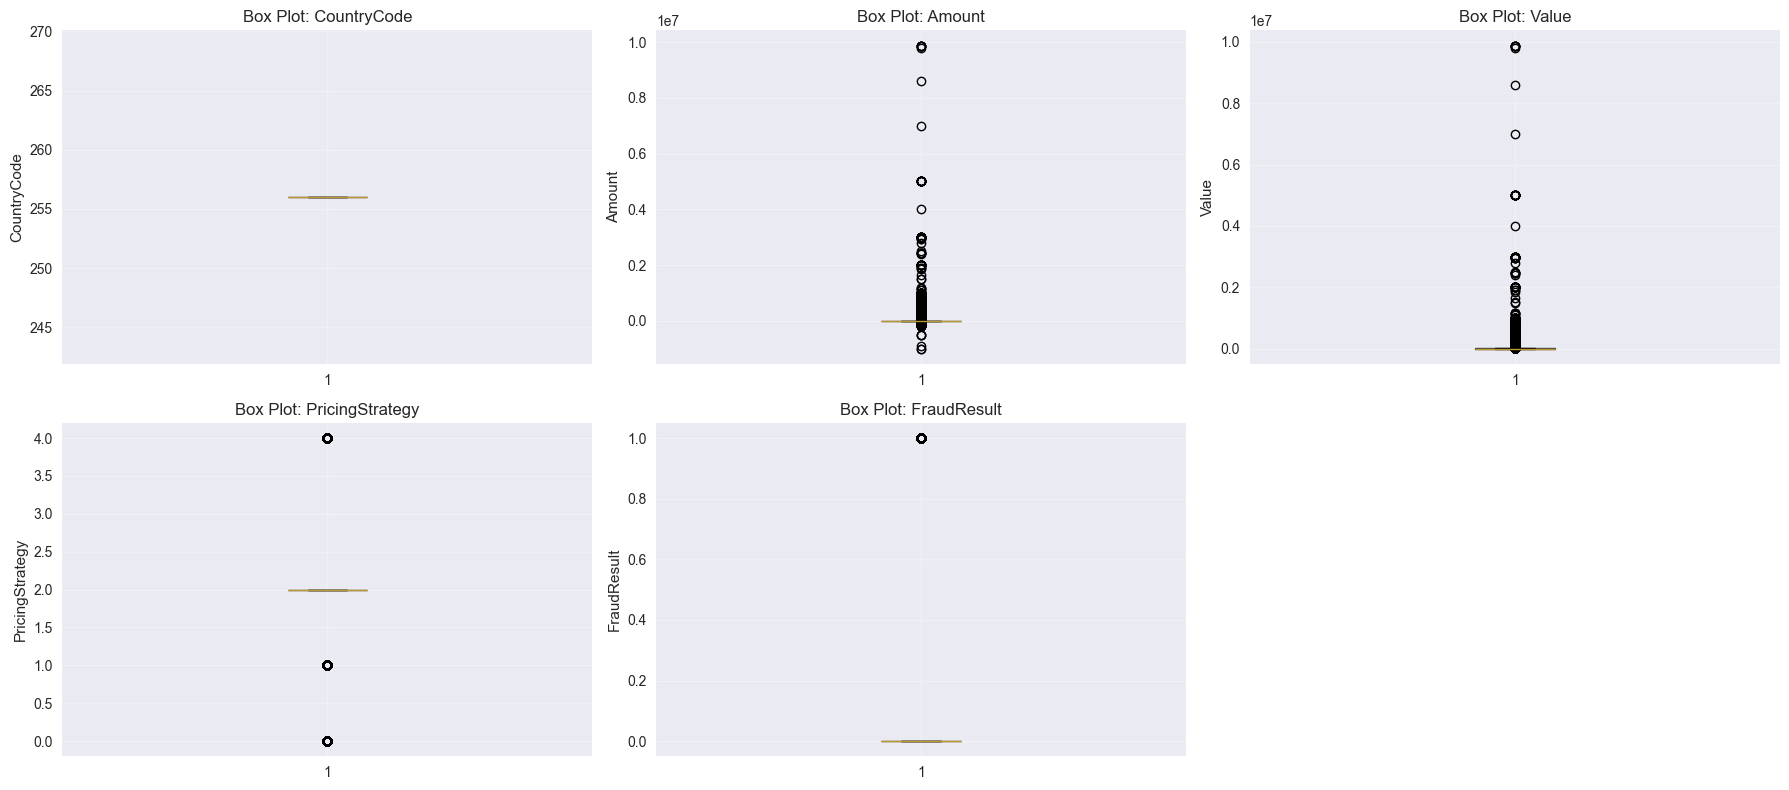


📊 Outlier Analysis Summary:


,Feature,Total_Records,Outliers_Count,Outliers_Percentage,Lower_Bound,Upper_Bound,Min_Value,Max_Value
0,CountryCode,95662,0,0.000000,256.0,256.0,256.0,256.0
1,Amount,95662,24441,25.549330,-4325.0,7075.0,-1000000.0,9880000.0
2,Value,95662,9021,9.430077,-6812.5,12087.5,2.0,9880000.0
3,PricingStrategy,95662,15814,16.531120,2.0,2.0,0.0,4.0
4,FraudResult,95662,193,0.201752,0.0,0.0,0.0,1.0



🚨 Features with High Outlier Percentage (>5%):


,Feature,Outliers_Count,Outliers_Percentage
1,Amount,24441,25.549330
2,Value,9021,9.430077
3,PricingStrategy,15814,16.531120



💰 Amount Outliers Analysis:
Outlier bounds: [-4325.00, 7075.00]
Outliers found: 24,441 (25.5%)
Outlier amount range: -1000000.00 to 9880000.00
Outlier amount mean: 23299.55
Fraud cases in Amount outliers: 191 (0.8%)
Overall fraud rate: 0.2%
Outliers are 3.9x more likely to be fraud


In [17]:
# Outlier detection using box plots and IQR method
print("📦 Detecting outliers using box plots and IQR method...")

# Create box plots for numerical features
if numerical_cols:
    n_cols = len(numerical_cols)
    n_rows = (n_cols + 2) // 3  # 3 plots per row
    
    plt.figure(figsize=(18, 4*n_rows))
    
    for i, col in enumerate(numerical_cols):
        plt.subplot(n_rows, 3, i+1)
        
        # Create box plot
        bp = plt.boxplot(df[col].dropna(), patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        bp['boxes'][0].set_alpha(0.7)
        
        plt.title(f'Box Plot: {col}')
        plt.ylabel(col)
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate outlier statistics
    print("\n📊 Outlier Analysis Summary:")
    outlier_summary = []
    
    for col in numerical_cols:
        outliers, lower_bound, upper_bound = detect_outliers_iqr(df, col)
        
        outlier_summary.append({
            'Feature': col,
            'Total_Records': len(df),
            'Outliers_Count': len(outliers),
            'Outliers_Percentage': (len(outliers) / len(df) * 100),
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound,
            'Min_Value': df[col].min(),
            'Max_Value': df[col].max()
        })
    
    outlier_df = pd.DataFrame(outlier_summary)
    display(outlier_df)
    
    # Extreme outliers analysis
    print("\n🚨 Features with High Outlier Percentage (>5%):")
    high_outlier_features = outlier_df[outlier_df['Outliers_Percentage'] > 5]
    if not high_outlier_features.empty:
        display(high_outlier_features[['Feature', 'Outliers_Count', 'Outliers_Percentage']])
    else:
        print("No features with high outlier percentage found.")
    
    # Special focus on Amount outliers if exists
    if 'Amount' in numerical_cols:
        amount_outliers, lower_bound, upper_bound = detect_outliers_iqr(df, 'Amount')
        
        print(f"\n💰 Amount Outliers Analysis:")
        print(f"Outlier bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
        print(f"Outliers found: {len(amount_outliers):,} ({len(amount_outliers)/len(df)*100:.1f}%)")
        
        if len(amount_outliers) > 0:
            print(f"Outlier amount range: {amount_outliers['Amount'].min():.2f} to {amount_outliers['Amount'].max():.2f}")
            print(f"Outlier amount mean: {amount_outliers['Amount'].mean():.2f}")
            
            # Check if outliers are related to fraud
            if 'FraudResult' in df.columns:
                fraud_in_outliers = amount_outliers['FraudResult'].sum()
                fraud_rate_outliers = fraud_in_outliers / len(amount_outliers) * 100
                overall_fraud_rate = df['FraudResult'].mean() * 100
                
                print(f"Fraud cases in Amount outliers: {fraud_in_outliers} ({fraud_rate_outliers:.1f}%)")
                print(f"Overall fraud rate: {overall_fraud_rate:.1f}%")
                print(f"Outliers are {fraud_rate_outliers/overall_fraud_rate:.1f}x more likely to be fraud")

else:
    print("⚠️ No numerical features available for outlier detection")


In [18]:
# Key Insights Summary
print("🎯 KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS")
print("=" * 60)

# This cell will be populated after running the analysis above
# Top 3-5 insights will be documented here based on findings

insights = [
    "1. DATA QUALITY & STRUCTURE:",
    "   - Document dataset size, missing values, and data types",
    "   - Identify any data quality issues found",
    "",
    "2. FEATURE DISTRIBUTIONS:",
    "   - Document key patterns in numerical features (skewness, outliers)",
    "   - Highlight important categorical feature distributions",
    "",
    "3. TARGET VARIABLE ANALYSIS:",
    "   - Document fraud rate and class imbalance if FraudResult exists",
    "   - Identify features strongly associated with fraud",
    "",
    "4. CORRELATION PATTERNS:",
    "   - Document significant correlations between features",
    "   - Identify potential multicollinearity issues",
    "",
    "5. OUTLIERS & ANOMALIES:",
    "   - Document outlier patterns and their business significance",
    "   - Assess relationship between outliers and fraud",
    "",
    "💡 RECOMMENDATIONS FOR FEATURE ENGINEERING:",
    "   - Log transformations for skewed features",
    "   - Encoding strategies for categorical variables",
    "   - Outlier treatment approaches",
    "   - Missing value imputation strategies",
    "",
    "📋 DATA PREPROCESSING PRIORITIES:",
    "   - List critical preprocessing steps identified",
    "   - Highlight potential proxy variables for credit risk",
    "   - Feature selection recommendations"
]

for insight in insights:
    print(insight)

print("\n" + "=" * 60)
print("📝 Note: Update this summary after running all analysis cells above")


🎯 KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS
1. DATA QUALITY & STRUCTURE:
   - Document dataset size, missing values, and data types
   - Identify any data quality issues found

2. FEATURE DISTRIBUTIONS:
   - Document key patterns in numerical features (skewness, outliers)
   - Highlight important categorical feature distributions

3. TARGET VARIABLE ANALYSIS:
   - Document fraud rate and class imbalance if FraudResult exists
   - Identify features strongly associated with fraud

4. CORRELATION PATTERNS:
   - Document significant correlations between features
   - Identify potential multicollinearity issues

5. OUTLIERS & ANOMALIES:
   - Document outlier patterns and their business significance
   - Assess relationship between outliers and fraud

💡 RECOMMENDATIONS FOR FEATURE ENGINEERING:
   - Log transformations for skewed features
   - Encoding strategies for categorical variables
   - Outlier treatment approaches
   - Missing value imputation strategies

📋 DATA PREPROCESSING PRIORI

In [19]:
# Additional Analysis Functions

def analyze_feature_by_target(df, feature, target='FraudResult'):
    """
    Analyze a feature's relationship with the target variable
    """
    if target not in df.columns:
        print(f"Target variable '{target}' not found in dataset")
        return
    
    print(f"📊 Analysis of {feature} by {target}:")
    
    if df[feature].dtype in ['object']:
        # Categorical feature
        crosstab = pd.crosstab(df[feature], df[target], margins=True)
        print("Cross-tabulation:")
        display(crosstab)
        
        # Fraud rate by category
        fraud_rates = df.groupby(feature)[target].agg(['count', 'sum', 'mean']).round(3)
        fraud_rates.columns = ['Total_Transactions', 'Fraud_Cases', 'Fraud_Rate']
        print(f"\nFraud rates by {feature}:")
        display(fraud_rates.sort_values('Fraud_Rate', ascending=False))
        
    else:
        # Numerical feature
        print(f"Statistics by {target}:")
        stats_by_target = df.groupby(target)[feature].describe()
        display(stats_by_target)
        
        # Box plot
        plt.figure(figsize=(8, 5))
        df.boxplot(column=feature, by=target)
        plt.title(f'{feature} Distribution by {target}')
        plt.show()

def time_series_analysis(df, date_column='TransactionStartTime'):
    """
    Analyze temporal patterns in the data
    """
    if date_column not in df.columns:
        print(f"Date column '{date_column}' not found")
        return
    
    # Convert to datetime if not already
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    
    # Extract time components
    df['Year'] = df[date_column].dt.year
    df['Month'] = df[date_column].dt.month
    df['Day'] = df[date_column].dt.day
    df['Hour'] = df[date_column].dt.hour
    df['DayOfWeek'] = df[date_column].dt.dayofweek
    
    print("📅 Temporal Analysis:")
    print(f"Date range: {df[date_column].min()} to {df[date_column].max()}")
    
    # Transactions by time period
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # By month
    monthly_counts = df['Month'].value_counts().sort_index()
    axes[0,0].bar(monthly_counts.index, monthly_counts.values, color='skyblue', alpha=0.8)
    axes[0,0].set_title('Transactions by Month')
    axes[0,0].set_xlabel('Month')
    axes[0,0].set_ylabel('Count')
    
    # By hour
    hourly_counts = df['Hour'].value_counts().sort_index()
    axes[0,1].bar(hourly_counts.index, hourly_counts.values, color='lightgreen', alpha=0.8)
    axes[0,1].set_title('Transactions by Hour')
    axes[0,1].set_xlabel('Hour')
    axes[0,1].set_ylabel('Count')
    
    # By day of week
    dow_counts = df['DayOfWeek'].value_counts().sort_index()
    axes[1,0].bar(dow_counts.index, dow_counts.values, color='coral', alpha=0.8)
    axes[1,0].set_title('Transactions by Day of Week')
    axes[1,0].set_xlabel('Day of Week (0=Monday)')
    axes[1,0].set_ylabel('Count')
    
    # Daily trend
    daily_counts = df[date_column].dt.date.value_counts().sort_index()
    axes[1,1].plot(daily_counts.index, daily_counts.values, color='purple', alpha=0.7)
    axes[1,1].set_title('Daily Transaction Trend')
    axes[1,1].set_xlabel('Date')
    axes[1,1].set_ylabel('Count')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def generate_summary_report(df):
    """
    Generate a comprehensive summary report
    """
    print("📋 COMPREHENSIVE DATA SUMMARY REPORT")
    print("=" * 50)
    
    print(f"📊 Dataset Overview:")
    print(f"   • Total Records: {len(df):,}")
    print(f"   • Total Features: {len(df.columns)}")
    print(f"   • Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"   • Date Range: {df.index.min() if hasattr(df.index, 'min') else 'N/A'}")
    
    print(f"\n🔢 Feature Types:")
    print(f"   • Numerical: {len(df.select_dtypes(include=[np.number]).columns)}")
    print(f"   • Categorical: {len(df.select_dtypes(include=['object']).columns)}")
    print(f"   • DateTime: {len(df.select_dtypes(include=['datetime64']).columns)}")
    
    print(f"\n🕳️ Data Quality:")
    missing_pct = (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100
    print(f"   • Missing Values: {missing_pct:.2f}%")
    print(f"   • Duplicate Rows: {df.duplicated().sum():,}")
    
    # Feature completeness
    completeness = ((df.count() / len(df)) * 100).sort_values(ascending=False)
    print(f"   • Most Complete Feature: {completeness.index[0]} ({completeness.iloc[0]:.1f}%)")
    print(f"   • Least Complete Feature: {completeness.index[-1]} ({completeness.iloc[-1]:.1f}%)")
    
    if 'FraudResult' in df.columns:
        fraud_rate = df['FraudResult'].mean() * 100
        print(f"\n🚨 Target Variable (FraudResult):")
        print(f"   • Fraud Rate: {fraud_rate:.2f}%")
        print(f"   • Class Balance: {100-fraud_rate:.2f}% vs {fraud_rate:.2f}%")

print("🛠️ Additional analysis functions loaded!")
print("Available functions:")
print("• analyze_feature_by_target(df, feature, target)")
print("• time_series_analysis(df, date_column)")
print("• generate_summary_report(df)")


🛠️ Additional analysis functions loaded!
Available functions:
• analyze_feature_by_target(df, feature, target)
• time_series_analysis(df, date_column)
• generate_summary_report(df)
